In [1]:
import os
import pandas as pd
data_path = os.getcwd() + "\9df3f148-2d4f-4286-b0db-cc3e0b180668.csv"
df = pd.read_csv(data_path)
df = df.rename(columns={c: c.lower() for c in df.columns})
print(df.head())

   type             start  end duration start condition start location  \
0  Bath   11/9/2023 19:31  NaN      NaN             NaN            NaN   
1  Bath   11/6/2023 18:51  NaN      NaN             NaN            NaN   
2  Bath   11/3/2023 20:21  NaN      NaN             NaN            NaN   
3  Bath  10/31/2023 19:21  NaN      NaN             NaN            NaN   
4  Bath  10/27/2023 18:51  NaN      NaN             NaN            NaN   

  end condition notes  
0           NaN   NaN  
1           NaN   NaN  
2           NaN   NaN  
3           NaN   NaN  
4           NaN   NaN  


In [5]:
# data processing
import datetime as dt
import numpy as np
import time

# event types that won't be covered
df = df[
    ~df['type'].isin([
        # columns with too few entries
        'Brush teeth', 'Indoor play', 'Outdoor play',
        # columns that don't indicate Eleanor's actions
        'Pump'
    ])
]

df['end'] = df['end'].fillna(df['start'])

def my_date_conversion(d):
    if isinstance(d, dt.datetime) or isinstance(d, dt.date):
        return d
    elif isinstance(d, pd.Timestamp):
        return pd.to_datetime(d)
        # return d.date()
    elif isinstance(d, str):
        for date_format in [
            '%Y-%m-%d %H:%M',
            '%m-%d-%Y %H:%M',
            '%Y-%m-%d',
            '%m-%d-%Y',
        ]:
            try:
                return dt.datetime.strptime(d.replace('/', '-').replace('T', ' '), date_format)
            except ValueError:
                pass
        raise ValueError(f"'{d}' is not a valid date format")
    elif isinstance(d, np.datetime64):
        return dt.datetime.utcfromtimestamp(d.tolist() / 1e9)
    else:
        raise ValueError(f"'{d}' ({type(d)}) is not a valid date format")

for c in ('start', 'end'):
    df[c] = df[c].apply(my_date_conversion)

# create better column names for each type
from collections import defaultdict
event_types = [
    'Solids', 'Sleep', 'Feed', 'Meds', 'Bath', 'Diaper', 'Brush teeth', 'Pump', 'Tummy time',
    'Skin to skin', 'Indoor play', 'Outdoor play'
]
base_columns = [
    'type', 'start', 'end', 'duration', 'start condition', 'start location', 'end condition', 'notes'
]
new_column_name_dict_list = {
    'Bath': {},
    'Brush teeth': {},
    'Diaper': {'duration': 'color', 'start condition': 'consistency', 'start location': 'issues', 'end condition': 'diaper contents'},
    'Feed': {'start condition': 'feed type', 'start location': 'delivery', 'end condition': 'amount'},
    'Indoor play': {},
    'Meds': {'start condition': 'amount', 'start location': 'name'},
    'Outdoor play': {},
    'Pump': {'start condition': 'amount'},
    'Skin to skin': {},
    'Sleep': {'start location': 'location'},
    'Solids': {'start condition': 'solids consumed', 'end condition': 'opinion'},
    'Tummy time': {},
}
event_column_dict = {}
default_dict = {c: c for c in base_columns}
for event_type in sorted(event_types):
    column_dict = {**default_dict}
    new_column_name_dict = new_column_name_dict_list[event_type]
    for old_col, new_col in new_column_name_dict.items():
        column_dict[old_col] = new_col
    event_column_dict[event_type] = column_dict
    # print(event_type, event_column_dict[event_type])

# split up entries that occur over two days (i.e. starts before midnight and ends after midnight)
rows_to_drop = []
rows_to_add = []
for idx, row in df.iterrows():
    if row['start'].date() != row['end'].date():
        row1 = row.copy(deep=True)
        row1['end'] = dt.datetime(row['start'].year, row['start'].month, row['start'].day, 23, 59)
        row2 = row.copy(deep=True)
        row2['start'] = dt.datetime(row['end'].year, row['end'].month, row['end'].day, 0, 0)
        rows_to_drop.append(idx)
        rows_to_add.append(row1)
        rows_to_add.append(row2)
  
for row in rows_to_add:
    df.loc[df.shape[0]] = row
df = df.drop(rows_to_drop)

# calculate a better duration column
time_unit = 'seconds'
# time_unit = 'minutes'
# time_unit = 'hours'
if time_unit == 'seconds':
    time_scale = 1.0
elif time_unit == 'minutes':
    time_scale = 60.0
elif time_unit == 'hours':
    time_scale = 60.0 * 60.0
minimum_true_duration = 5.0 * 60.0 / time_scale
# minimum_true_duration = 0.0
df = df.assign(true_duration=(df['end'] - df['start']).apply(
    lambda d: minimum_true_duration if d.seconds == 0.0 else d.seconds / time_scale
))

df = df.sort_values('start')
# df.tail(5)
# df[df['type'] == 'Feed'].sort_values('start').head(50)


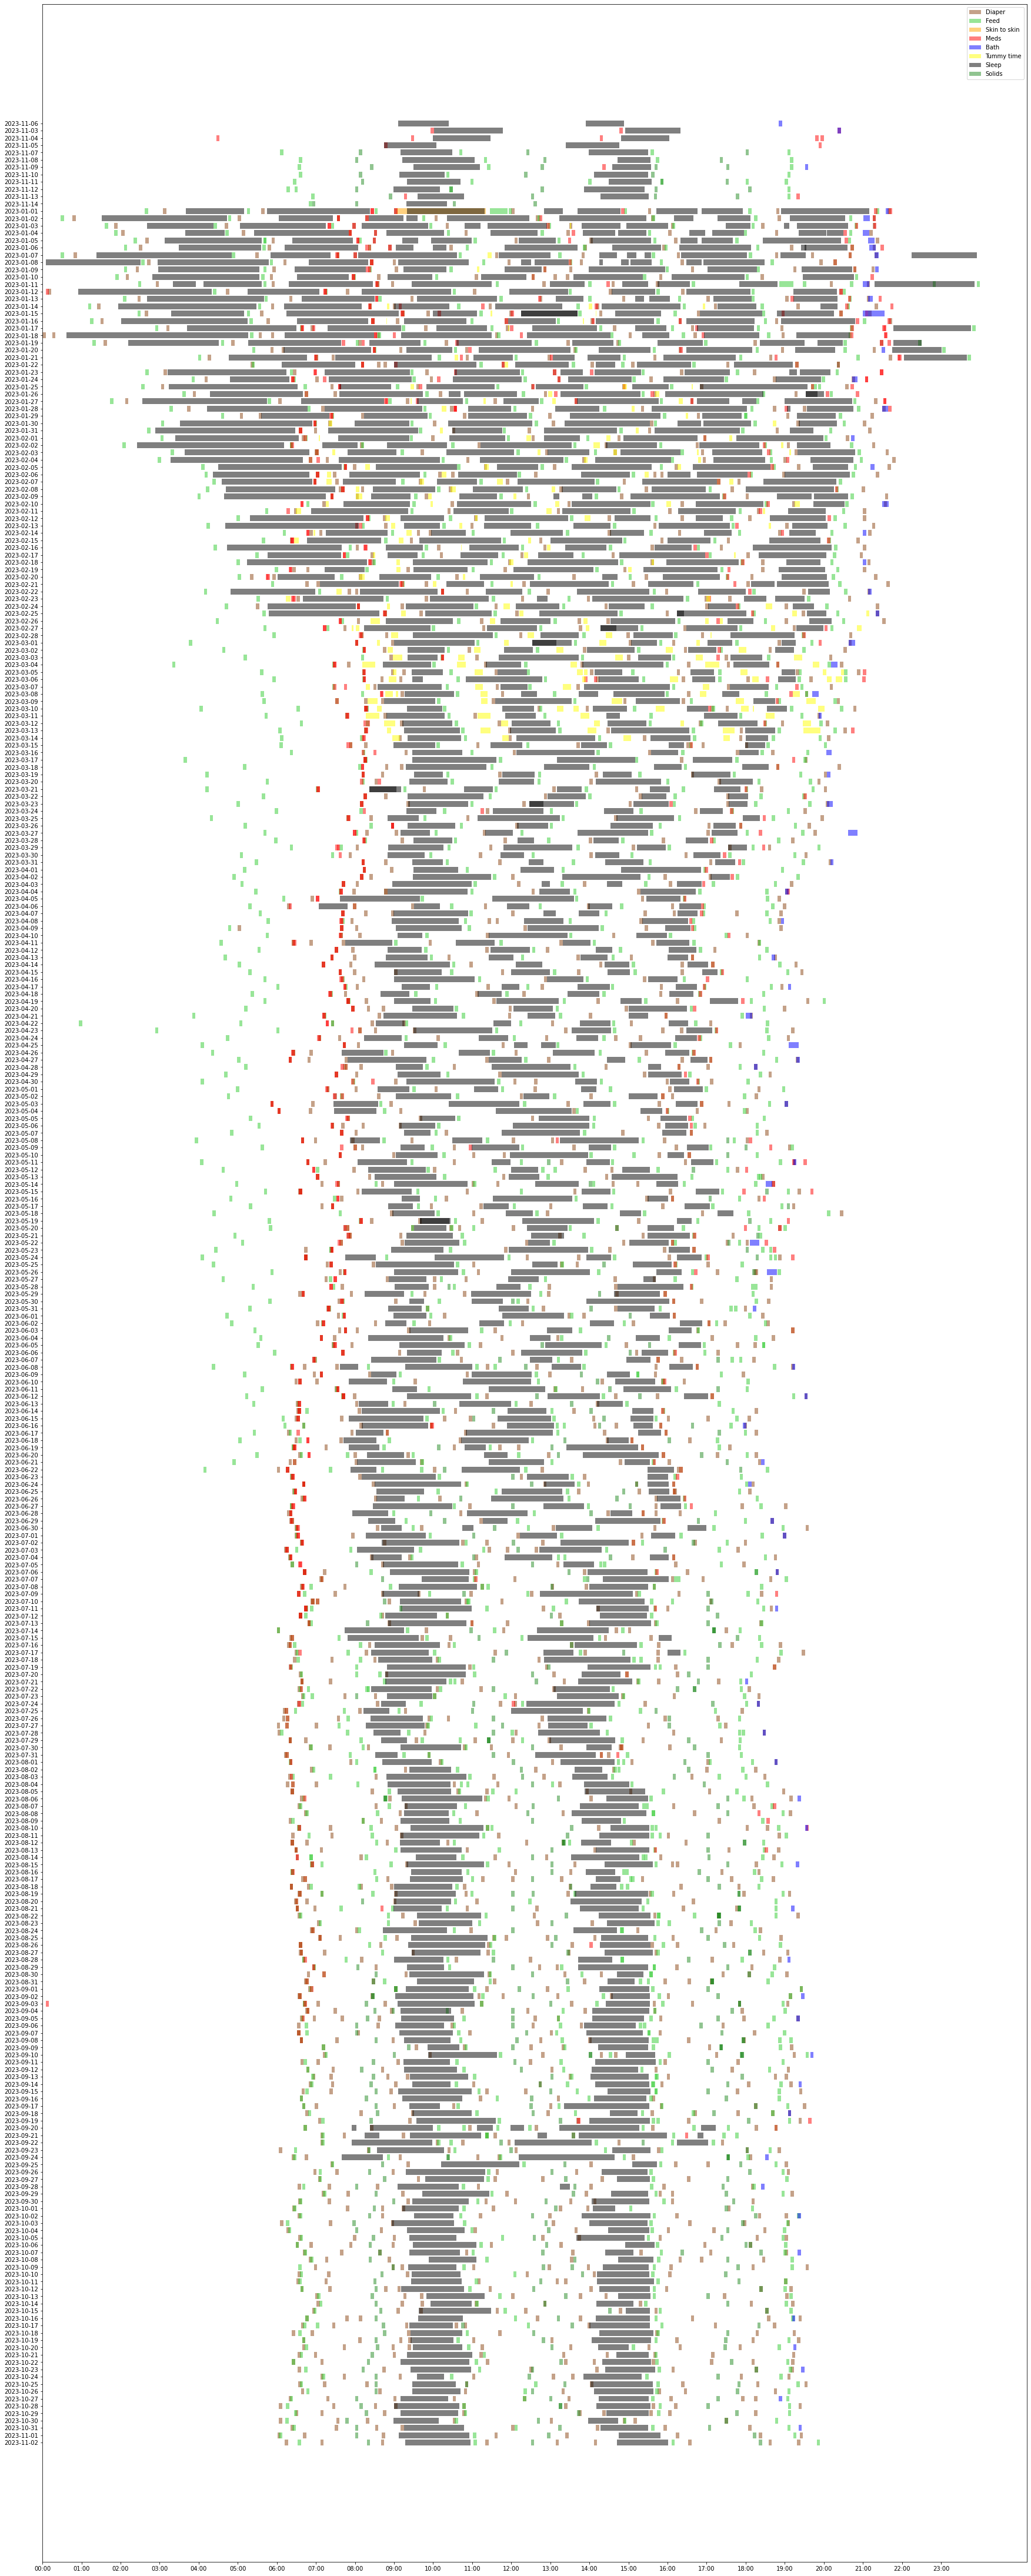

In [6]:
import matplotlib.pyplot as plt

def convert_num_seconds_to_time_of_day(t):
    return time.strftime('%H:%M', time.gmtime(t))

# edf = df[
#     (df['start'] >= dt.datetime(2023, 11, 13)) &
#     (df['start'] < dt.datetime(2023, 11, 14))
#     # (df['start'] >= dt.datetime(2023, 10, 21)) &
#     # (df['start'] < dt.datetime(2023, 10, 22))
#     # (df['start'] < dt.datetime(2023, 10, 28))
# ]

# 'Solids', 'Sleep', 'Feed', 'Meds', 'Bath', 'Diaper', 'Brush teeth', 'Pump', 'Tummy time', 'Skin to skin', 'Indoor play', 'Outdoor play'
event_color_dict = {
    'sleep': 'black',
    'feed': 'limegreen',
    'solids': 'forestgreen',
    'diaper': 'saddlebrown',
    'meds': 'red',
    'bath': 'blue',
    'brush teeth': 'pink',
    'tummy time': 'yellow',
    'skin to skin': 'orange',
    'indoor play': 'purple',
    'outdoor play': 'magenta'
}

plot_date_filters = [
    # dt.datetime(2023, 11, 2), dt.datetime(2023, 11, 5)
    # dt.datetime(2022, 11, 2), dt.datetime(2022, 12, 3)
    dt.datetime(2023, 1, 1),
    dt.datetime(2023, 12, 1)
]

# minimum and maximum hours of the day covered by the data. used to bound the plot
min_hour = 24
max_hour = 0

fig, ax = plt.subplots(figsize=(30, 80))
for ET in df['type'].unique():#['Sleep', 'Feed']:
    # "event data frame"
    edf = df[(df['start'] >= plot_date_filters[0]) & (df['start'] < plot_date_filters[1])].sort_values('start', ascending=False)
    edf = edf[edf['type'] == ET].rename(columns=event_column_dict[ET])
    edf['start_date'] = edf['start'].apply(lambda d: d.date())
    edf['end_date'] = edf['end'].apply(lambda d: d.date())

    # calculate start/end time as seconds from midnight
    edf['start_time'] = (edf['start'] - edf['start'].apply(lambda d: dt.datetime(d.year, d.month, d.day))).apply(lambda d: d.seconds)
    edf['end_time'] = (edf['end'] - edf['start'].apply(lambda d: dt.datetime(d.year, d.month, d.day))).apply(lambda d: d.seconds)
    edf['plot_duration'] = (
        edf['end'] - edf['start']
    ).apply(lambda d: minimum_true_duration if d.seconds == 0.0 else d.seconds / time_scale)
    try:
        min_hour = min(
            min_hour,
            time.gmtime(edf['start_time'].astype(int).min())[3],
            time.gmtime(edf['end_time'].astype(int).min())[3]
        )
        max_hour = max(
            max_hour,
            time.gmtime(edf['start_time'].astype(int).max())[3],
            time.gmtime(edf['end_time'].astype(int).max())[3]
        )
    except:
        pass
        # print(edf['start_time'].min(), edf['end_time'].min())
        # print(edf['start_time'].max(), edf['end_time'].max())

    # print(edf[['type', 'start', 'end', 'true_duration', 'start_time', 'end_time']])
    plt.barh(
        y=edf['start'].apply(lambda d: d.date().strftime('%Y-%m-%d')),
        width=edf['plot_duration'],
        left=edf['start_time'],
        label=ET,
        color=event_color_dict[ET.lower()],
        alpha=0.5
    )

if max_hour <= min_hour:  # last minute catch-all
    min_hour, max_hour = 0, 24
# min_hour = 6
hour_ticks = list(range(min_hour * 60 * 60, (max_hour + 1) * 60 * 60, 60 * 60))
ax.set_xticks(hour_ticks)
ax.set_xticklabels([convert_num_seconds_to_time_of_day(x) for x in hour_ticks])
plt.legend()
plt.show()



In [395]:
#df[(df['start'] >= dt.datetime(2023, 11, 2)) & (df['start'] < dt.datetime(2023, 11, 3)) | (df['end'] >= dt.datetime(2023, 11, 2)) & (df['start'] < dt.datetime(2023, 11, 3))].sort_values('start')
#time.strftime('%H:%M', time.gmtime(40000))
# time.gmtime(
# edf['start_time'].min()
    # )[3]
[convert_num_seconds_to_time_of_day(x) for x in range(min_hour * 60 * 60, (max_hour + 1) * 60 * 60, 60 * 60)]

['06:00',
 '07:00',
 '08:00',
 '09:00',
 '10:00',
 '11:00',
 '12:00',
 '13:00',
 '14:00',
 '15:00',
 '16:00',
 '17:00',
 '18:00',
 '19:00']

In [367]:
edf[edf['start_date'] == dt.date(2023, 7, 1)]

,type,start,end,duration,start condition,location,end condition,notes,true_duration,start_date,end_date,start_time,end_time,plot_duration
7929,Sleep,2023-07-01 08:17:00,2023-07-01 09:49:00,1:31,NaN,NaN,NaN,NaN,5520.0,2023-07-01,2023-07-01,29820,35340,5520.0
7928,Sleep,2023-07-01 12:13:00,2023-07-01 13:10:00,0:56,NaN,NaN,NaN,NaN,3420.0,2023-07-01,2023-07-01,43980,47400,3420.0
7927,Sleep,2023-07-01 15:35:00,2023-07-01 16:12:00,0:37,NaN,NaN,NaN,NaN,2220.0,2023-07-01,2023-07-01,56100,58320,2220.0


In [197]:
df[
    (df['type'].isin(['Feed', 'Bath']))# & (df['end'] - df['start']).apply(lambda d: d.seconds > 0)
    # (df['start'] >= dt.datetime(2023, 10, 26)) & (df['start'] < dt.datetime(2023, 11, 3)) |
    # (df['end'] >= dt.datetime(2023, 10, 26)) & (df['start'] < dt.datetime(2023, 11, 3))
].sort_values('duration', ascending=False).head(20)

,type,start,end,duration,start condition,start location,end condition,notes,true_duration
9624,Feed,2022-11-04 23:53:00,2022-11-05 00:28:00,00:35,00:16R,Breast,00:18L,NaN,35.0
7145,Bath,2023-01-15 21:00:00,2023-01-15 21:33:00,00:33,NaN,NaN,NaN,cradle cap shampoo,33.0
8337,Feed,2022-12-14 10:08:00,2022-12-14 10:41:00,00:32,00:20R,Breast,00:12L,NaN,33.0
8007,Feed,2022-12-24 18:12:00,2022-12-24 18:44:00,00:32,00:13R,Breast,00:18L,NaN,32.0
9666,Feed,2022-11-02 20:34:00,2022-11-02 21:06:00,00:31,00:18R,Breast,00:13L,NaN,32.0
9645,Feed,2022-11-04 04:49:00,2022-11-04 05:19:00,00:30,00:15R,Breast,00:15L,NaN,30.0
9615,Feed,2022-11-05 07:33:00,2022-11-05 08:03:00,00:30,00:11R,Breast,00:19L,NaN,30.0
8637,Feed,2022-12-05 09:35:00,2022-12-05 10:05:00,00:30,00:15R,Breast,00:15L,NaN,30.0
9664,Feed,2022-11-02 23:08:00,2022-11-02 23:37:00,00:28,Null r,Breast,00:28L,NaN,29.0
7705,Feed,2023-01-01 11:27:00,2023-01-01 11:54:00,00:27,00:08R,Breast,00:18L,NaN,27.0


In [174]:
foo = df.sort_values('start')
for i in range(0,
               30
            #    df.shape[0] - 1
               ):
    my_end = foo.iloc[i]['end']
    next_start = foo.iloc[i + 1]['start']
    if my_end > next_start:
        print('~' * 25)
        print(foo.iloc[i])
        print('- - -')
        print(foo.iloc[i + 1])

~~~~~~~~~~~~~~~~~~~~~~~~~
type                              Pump
start              2022-11-04 04:36:00
end                2022-11-04 04:51:00
duration                         00:15
start condition                    0oz
start location                     NaN
end condition                      NaN
notes                              NaN
Name: 9646, dtype: object
- - -
type                              Feed
start              2022-11-04 04:49:00
end                2022-11-04 05:19:00
duration                         00:30
start condition                 00:15R
start location                  Breast
end condition                   00:15L
notes                              NaN
Name: 9645, dtype: object


In [192]:
import matplotlib.pyplot as plt
import numpy as np

category_names = list(event_types)
df['true_duration'] = (df['end'] - df['start']).apply(
    lambda d:
        # max(1,
            d.seconds / 60
        # )
    )

results = {}
for i in range(0, 7):
    day = dt.datetime(2023, 10, 27) + dt.timedelta(days=i)
    print(day)
    results[day.strftime('%Y-%m-%d')] = \
        list(df[
            (df['start'] >= day) & (df['start'] < day + dt.timedelta(days=1)) |
            (df['end'] >= day) & (df['start'] < day + dt.timedelta(days=1))
        ].groupby('type')['true_duration'].sum().values)

results
# results = {
#     'Question 1': [10, 15, 17, 32, 26],
#     'Question 2': [26, 22, 29, 10, 13],
#     'Question 3': [35, 37, 7, 2, 19],
#     'Question 4': [32, 11, 9, 15, 33],
#     'Question 5': [21, 29, 5, 5, 40],
#     'Question 6': [8, 19, 5, 30, 38]
# }


# def survey(results, category_names):
#     """
#     Parameters
#     ----------
#     results : dict
#         A mapping from question labels to a list of answers per category.
#         It is assumed all lists contain the same number of entries and that
#         it matches the length of *category_names*.
#     category_names : list of str
#         The category labels.
#     """
#     labels = list(results.keys())
#     data = np.array(list(results.values()))
#     data_cum = data.cumsum(axis=1)
#     category_colors = plt.colormaps['RdYlGn'](
#         np.linspace(0.15, 0.85, data.shape[1]))

#     fig, ax = plt.subplots(figsize=(9.2, 5))
#     ax.invert_yaxis()
#     ax.xaxis.set_visible(False)
#     ax.set_xlim(0, np.sum(data, axis=1).max())

#     for i, (colname, color) in enumerate(zip(category_names, category_colors)):
#         widths = data[:, i]
#         starts = data_cum[:, i] - widths
#         rects = ax.barh(labels, widths, left=starts, height=0.5,
#                         label=colname, color=color)

#         r, g, b, _ = color
#         text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
#         ax.bar_label(rects, label_type='center', color=text_color)
#     ax.legend(ncols=len(category_names), bbox_to_anchor=(0, 1),
#               loc='lower left', fontsize='small')

#     return fig, ax


# survey(results, category_names)
# plt.show()

2023-10-27 00:00:00
2023-10-28 00:00:00
2023-10-29 00:00:00
2023-10-30 00:00:00
2023-10-31 00:00:00
2023-11-01 00:00:00
2023-11-02 00:00:00


{'2023-10-27': [0.0, 0.0, 0.0, 1416.0, 0.0],
 '2023-10-28': [0.0, 0.0, 1446.0, 0.0],
 '2023-10-29': [0.0, 0.0, 1411.0, 0.0],
 '2023-10-30': [0.0, 0.0, 1409.0, 0.0],
 '2023-10-31': [0.0, 0.0, 0.0, 1430.0, 0.0],
 '2023-11-01': [0.0, 0.0, 1388.0, 0.0],
 '2023-11-02': [0.0, 0.0, 1420.0, 0.0]}

In [198]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import datetime

trace1 = go.Bar(
    y = ['Task 1', 'Task 1'],
    base = [1, 2.5],
    x = [0.5, 1],
    orientation = 'h' 
)


fig = go.Figure(data=[trace1])
iplot(fig)

# trace0 = go.Bar(
#     y = ['Task 1', 'Task 1'],
#     base = [datetime.datetime(2018, 7, 23, 1, 0),
#             datetime.datetime(2018, 7, 23, 2, 30)],
#     x = [datetime.time(0, 30),
#          datetime.time(1, 0)],
#     orientation = 'h' 
# )

# fig = go.Figure(data=[trace0])
# iplot(fig)

ModuleNotFoundError: No module named 'plotly'

In [199]:
# plot every activity's total time per day
df

,type,start,end,duration,start condition,start location,end condition,notes,true_duration
0,Solids,2023-11-14 12:34:00,2023-11-14 12:34:00,NaN,NaN,Solids,NaN,NaN,0.0
1,Solids,2023-11-14 10:30:00,2023-11-14 10:30:00,NaN,NaN,Solids,NaN,NaN,0.0
2,Sleep,2023-11-14 09:19:00,2023-11-14 10:21:00,01:02,NaN,NaN,NaN,NaN,62.0
3,Solids,2023-11-14 08:00:00,2023-11-14 08:00:00,NaN,NaN,Solids,NaN,NaN,0.0
4,Solids,2023-11-14 06:54:00,2023-11-14 06:54:00,NaN,NaN,Solids,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...
9663,Feed,2022-11-02 23:56:00,2022-11-03 00:20:00,00:23,00:23R,Breast,Null l,NaN,24.0
9664,Feed,2022-11-02 23:08:00,2022-11-02 23:37:00,00:28,Null r,Breast,00:28L,NaN,29.0
9665,Diaper,2022-11-02 23:02:00,2022-11-02 23:02:00,NaN,NaN,NaN,Both,NaN,0.0
9666,Feed,2022-11-02 20:34:00,2022-11-02 21:06:00,00:31,00:18R,Breast,00:13L,NaN,32.0


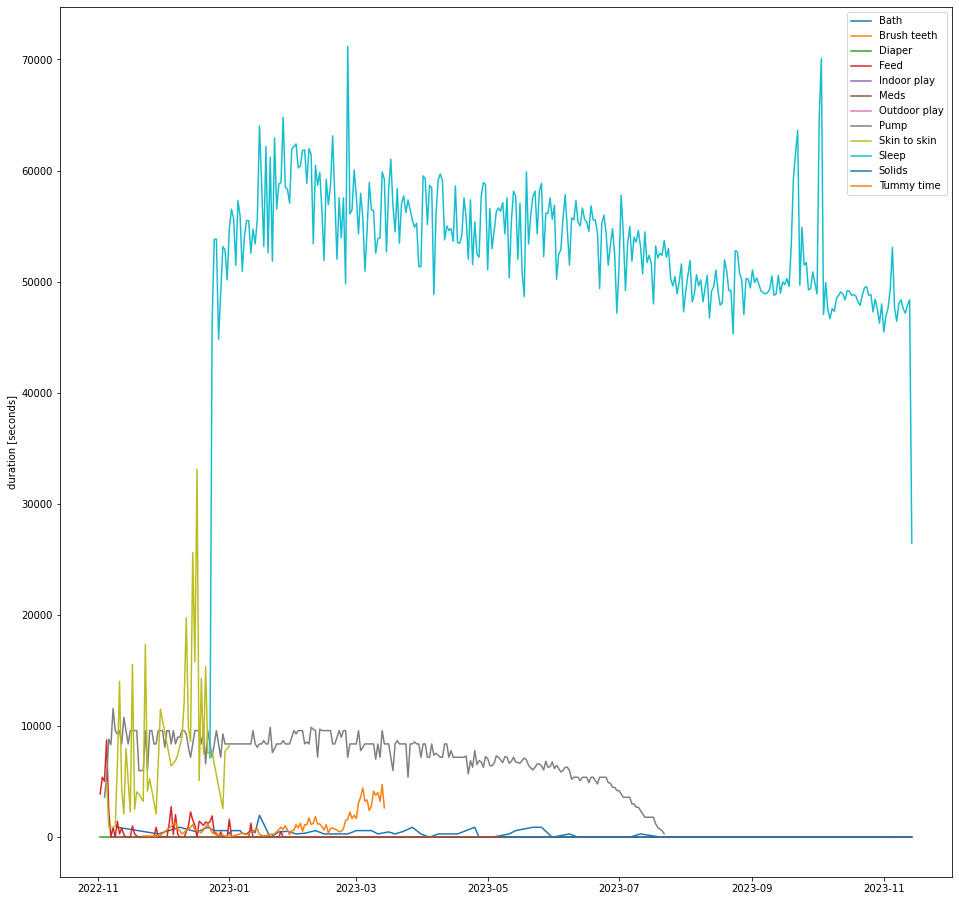

type
Bath               24840.0
Brush teeth            0.0
Diaper                 0.0
Feed               58800.0
Indoor play          120.0
Meds                   0.0
Outdoor play         600.0
Pump             1912740.0
Skin to skin      351660.0
Sleep           17451360.0
Solids                 0.0
Tummy time         94980.0
Name: true_duration, dtype: float64


In [258]:
plt.figure(figsize=(16, 16))
for event_type in df['type'].unique():
    ts = df[df['type'] == event_type].assign(
        start_date=df['start'].apply(lambda d: d.date())
    ).groupby('start_date')['true_duration'].sum()
    plt.plot(ts, label=event_type)
plt.ylabel(f"duration [{time_unit}]")
plt.legend()
plt.show()
print(df.groupby('type')['true_duration'].sum())

In [230]:
dt.datetime.strptime('11/9/2023 19:31',
                    '%m/%d/%Y %H:%M'
                    #  '%m-%d-%Y %H:%M'
                    #  '%Y-%m-%d %H:%M'
                    )
# dt.datetime(2023, 11, 9, 19, 31, 0).strftime('%m/%d/%Y %H:%M')

datetime.datetime(2023, 11, 9, 19, 31)

In [261]:
# how many events have a duration of zero?
df.groupby('type')['true_duration'].agg([
    lambda x: int(len([ix for ix in x if ix == 0.0])),
    lambda x: int(len([ix for ix in x if ix > 0.0]))
])

,<lambda_0>,<lambda_1>
type,,
Bath,39.0,46.0
Brush teeth,4.0,0.0
Diaper,2401.0,0.0
Feed,2459.0,79.0
Indoor play,0.0,1.0
Meds,865.0,0.0
Outdoor play,0.0,1.0
Pump,34.0,1506.0
Skin to skin,1.0,78.0


datetime.datetime(2023, 11, 2, 14, 42)